In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import string
import re
import nltk
import ssl
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
import scipy
import gensim.downloader as api
from scipy.spatial import distance

In [2]:
# nltk.download('wordnet') # for lemmatization
# nltk.download('averaged_perceptron_tagger') # for SoP
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [3]:
df = pd.read_csv('netflix_titles.csv')
print(df.shape[0])
df.head()

8807


show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021          2021  TV-MA   1 Season   
3  September 24, 2021          2021  TV-MA   1 Season   
4  September 24, 2021          2021  TV-MA  2 Seasons   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   
4  International TV Shows, Romantic TV Shows, TV ...   

                                         description  
0  As her father nears the end of his life, filmm...  
1  After crossing paths at a party, a Cape Town t...  
2  To protect his family from a powerful drug lor...  
3  Feuds, flirtations and toilet talk go down amo...  
4  In a city of coaching centers known to train I...

In [4]:
# create a Series labeled by the name of all the countries in the dataframe
countries = df.loc[:,'country']
countries = countries.dropna()
country_list = []
for cc in countries:
    lst = cc.split(',')
    lst = [x.strip(' ') for x in lst if x != '']
    for c in lst:
        if c not in country_list:
            country_list.append(c)
print(len(country_list))

122


In [5]:
# count number of movies produced by each country
c_count = pd.Series(np.zeros(len(country_list), dtype=int), index = country_list)
for c in country_list:
    count = 0
    for x in countries:
        lst = x.split(',')
        lst = [x.strip(' ') for x in lst if x != '']
        for i in lst:
            if c == i:
                count += 1
    c_count.loc[c] = count

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None
                      ):
    print(c_count)

United States           3690
South Africa              62
India                   1046
Ghana                      5
Burkina Faso               1
United Kingdom           806
Germany                  226
Ethiopia                   1
Czech Republic            22
Mexico                   169
Turkey                   113
Australia                160
France                   393
Finland                   11
China                    162
Canada                   445
Japan                    318
Nigeria                  103
Spain                    232
Belgium                   90
South Korea              231
Singapore                 41
Italy                    100
Romania                   14
Argentina                 91
Venezuela                  4
Hong Kong                105
Russia                    27
Ireland                   46
Nepal                      2
New Zealand               33
Brazil                    97
Greece                    11
Jordan                     9
Colombia      

In [6]:
# find movies produced by Iran
iran_movies = []
df_temp = df.drop(labels = df[df.country.isna()].index)
for i in range(df_temp.shape[0]):
    cc = df_temp.iloc[i].country
    lst = cc.split(',')
    lst = [x.strip(' ') for x in lst if x != '']
    for c in lst:
        if c == 'Iran':
            iran_movies.append(df_temp.iloc[i].show_id)

for id in iran_movies:
    display(df[df.show_id == id])

show_id   type                       title      director  \
4418   s4419  Movie  The Other Side of the Wind  Orson Welles   

                                                   cast  \
4418  John Huston, Oja Kodar, Peter Bogdanovich, Sus...   

                          country        date_added  release_year rating  \
4418  France, Iran, United States  November 2, 2018          2018      R   

     duration                                   listed_in  \
4418  122 min  Classic Movies, Dramas, Independent Movies   

                                            description  
4418  On the last day of his life, a legendary direc...

show_id   type             title      director  \
5641   s5642  Movie  Under the Shadow  Babak Anvari   

                                                   cast  \
5641  Narges Rashidi, Avin Manshadi, Bobby Naderi, R...   

                                  country       date_added  release_year  \
5641  United Kingdom, Jordan, Qatar, Iran  January 7, 2017          2016   

     rating duration                                       listed_in  \
5641  PG-13   84 min  Horror Movies, International Movies, Thrillers   

                                            description  
5641  During the Iran-Iraq conflict, a Tehran woman ...

show_id   type         title        director  \
6056   s6057  Movie  A Separation  Asghar Farhadi   

                                                   cast       country  \
6056  Leila Hatami, Peyman Moaadi, Shahab Hosseini, ...  Iran, France   

          date_added  release_year rating duration  \
6056  March 16, 2019          2011  PG-13  123 min   

                         listed_in  \
6056  Dramas, International Movies   

                                            description  
6056  Amid an impasse in his marriage, a father in T...

show_id   type              title      director  \
6293   s6294  Movie  Beyond the Clouds  Majid Majidi   

                                                   cast      country  \
6293  Ishaan Khattar, Malavika Mohanan, Goutam Ghose...  India, Iran   

           date_added  release_year rating duration  \
6293  August 10, 2018          2018  TV-14  120 min   

                                             listed_in  \
6293  Dramas, Independent Movies, International Movies   

                                            description  
6293  A youthful drug dealer in Mumbai must change h...

In [7]:
# create a list of available genres
film_genres = df.loc[:,'listed_in']
film_genres = film_genres.dropna()
genre_list = []
for tt in film_genres:
    lst = tt.split(',')
    lst = [x.strip(' ') for x in lst if x != '']
    for t in lst:
        if t not in genre_list:
            genre_list.append(t)
print(len(genre_list))
genre_list

42


['Documentaries',
 'International TV Shows',
 'TV Dramas',
 'TV Mysteries',
 'Crime TV Shows',
 'TV Action & Adventure',
 'Docuseries',
 'Reality TV',
 'Romantic TV Shows',
 'TV Comedies',
 'TV Horror',
 'Children & Family Movies',
 'Dramas',
 'Independent Movies',
 'International Movies',
 'British TV Shows',
 'Comedies',
 'Spanish-Language TV Shows',
 'Thrillers',
 'Romantic Movies',
 'Music & Musicals',
 'Horror Movies',
 'Sci-Fi & Fantasy',
 'TV Thrillers',
 "Kids' TV",
 'Action & Adventure',
 'TV Sci-Fi & Fantasy',
 'Classic Movies',
 'Anime Features',
 'Sports Movies',
 'Anime Series',
 'Korean TV Shows',
 'Science & Nature TV',
 'Teen TV Shows',
 'Cult Movies',
 'TV Shows',
 'Faith & Spirituality',
 'LGBTQ Movies',
 'Stand-Up Comedy',
 'Movies',
 'Stand-Up Comedy & Talk Shows',
 'Classic & Cult TV']

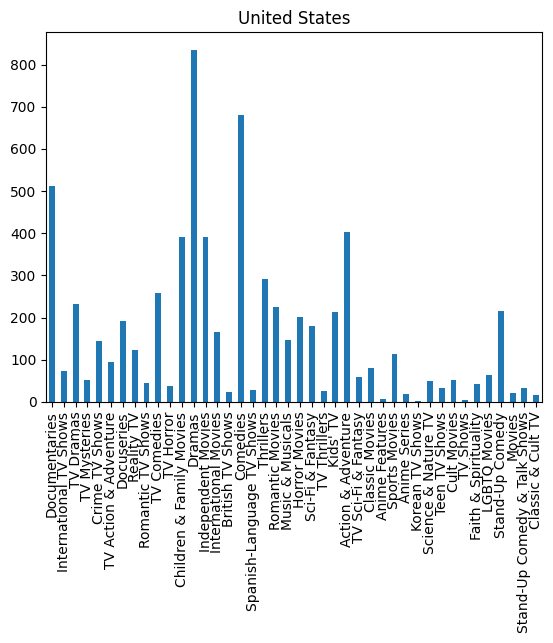

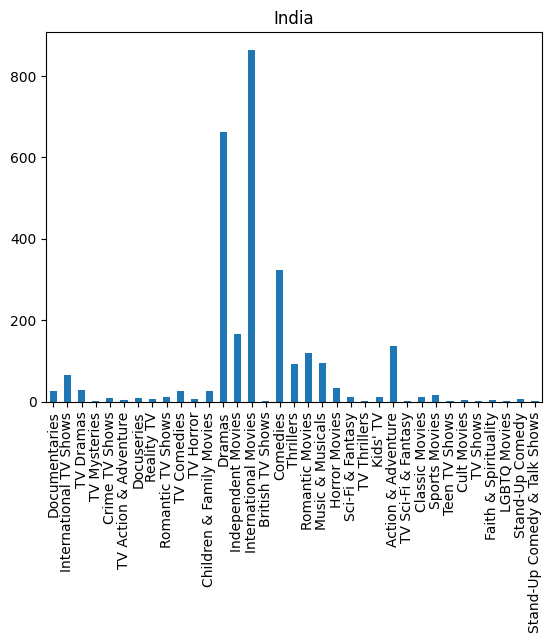

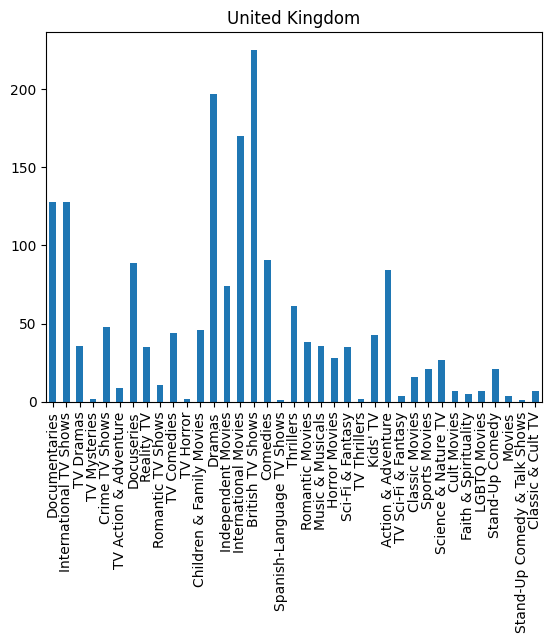

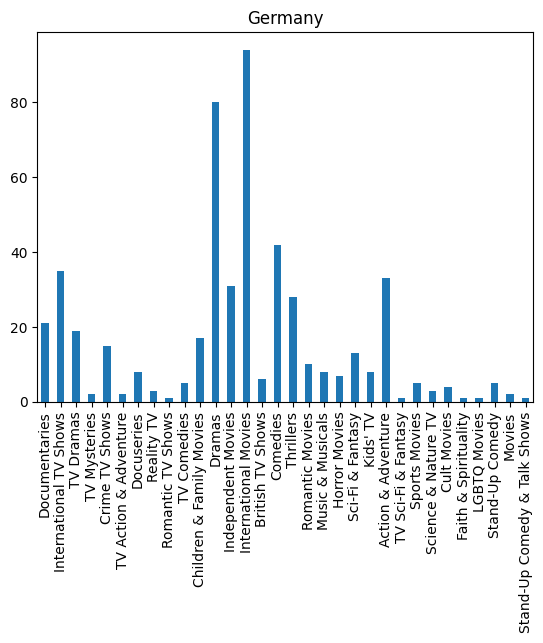

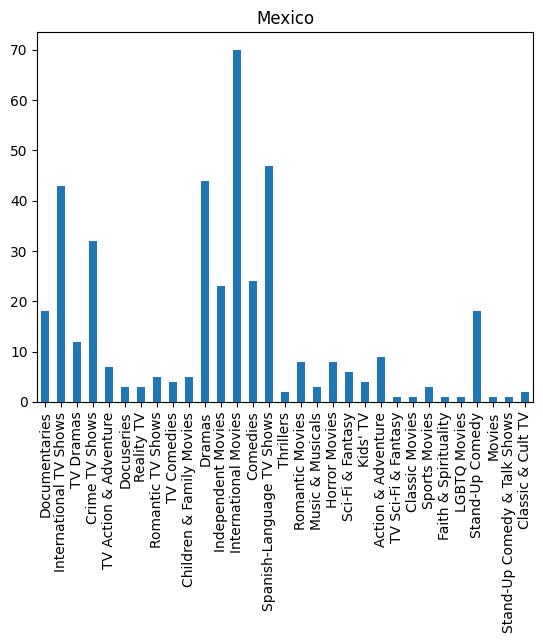

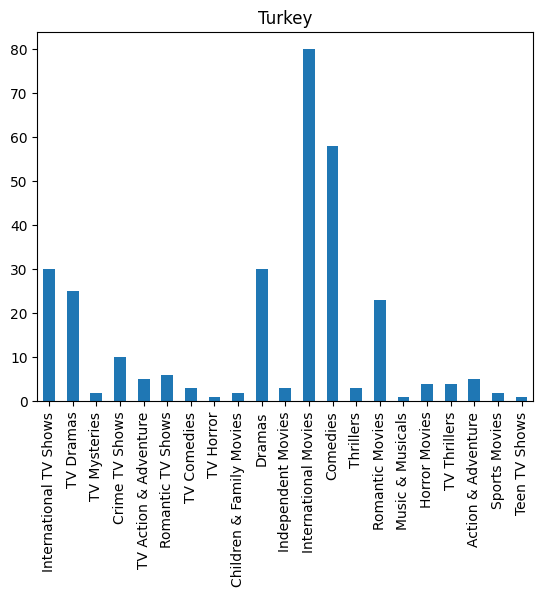

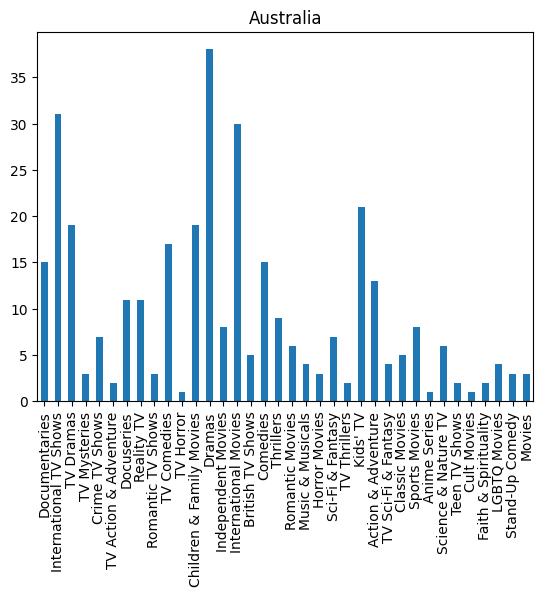

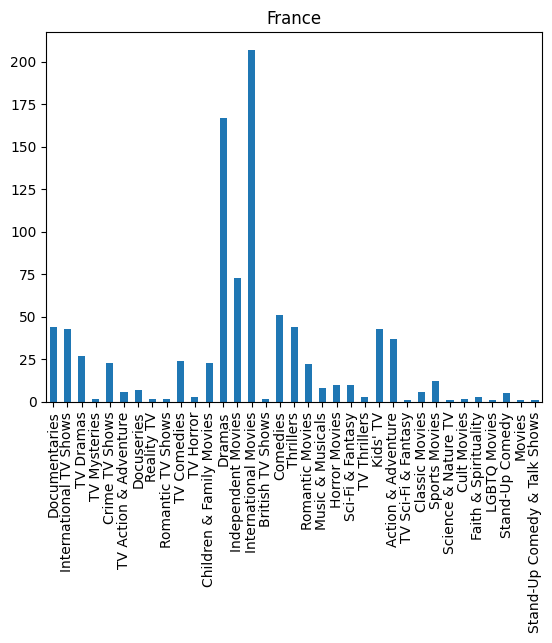

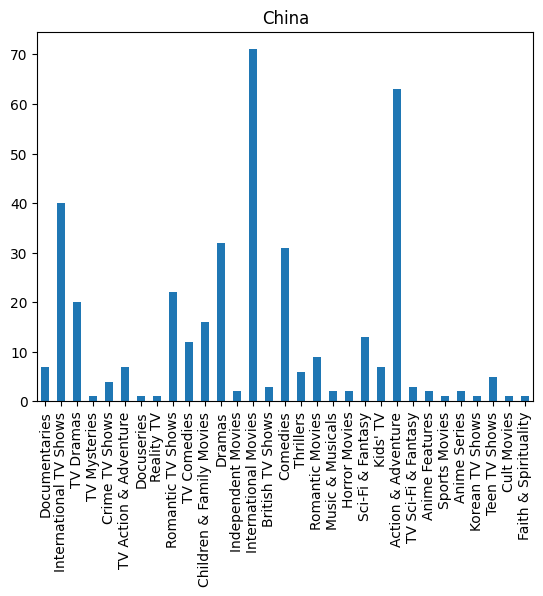

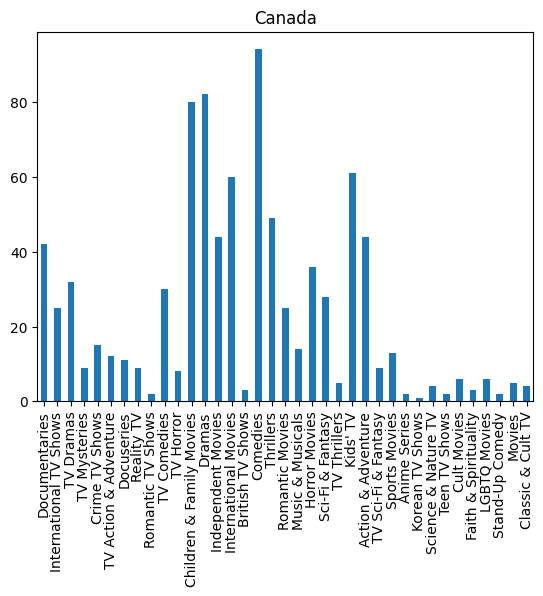

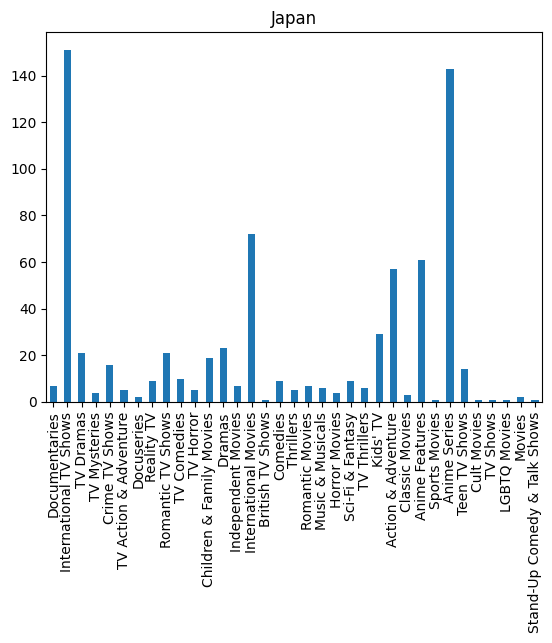

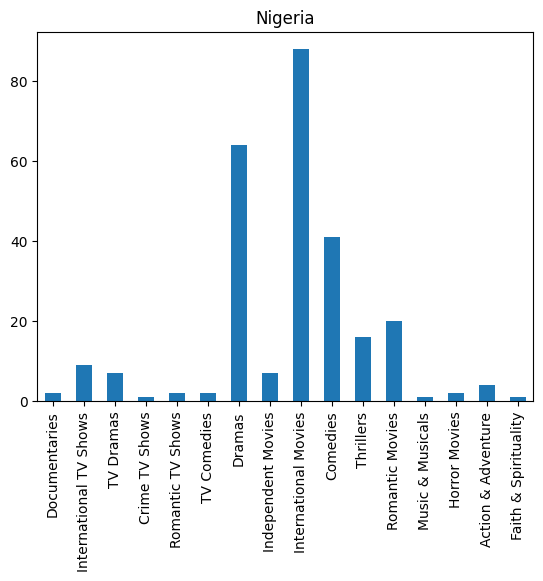

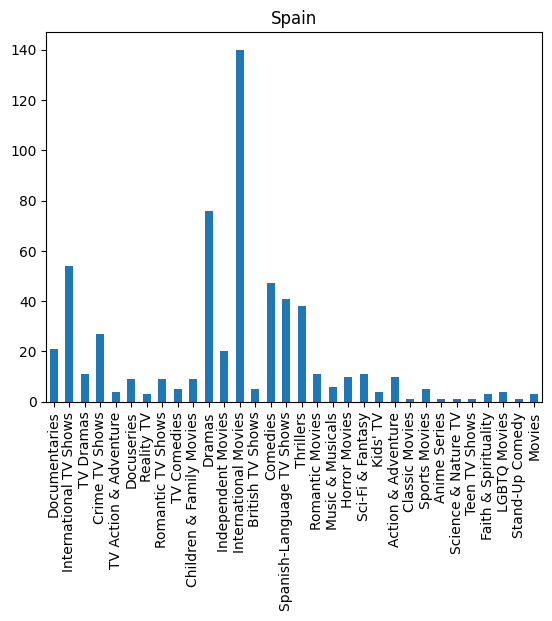

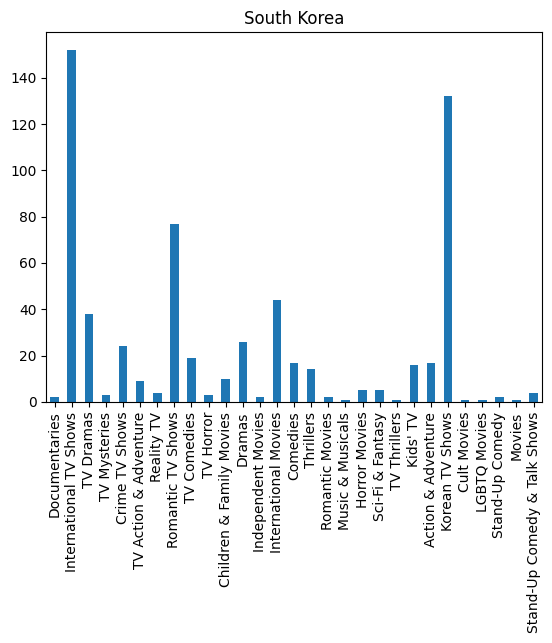

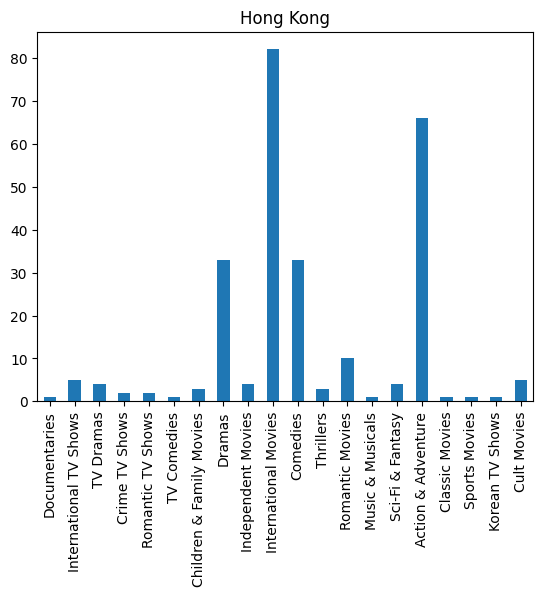

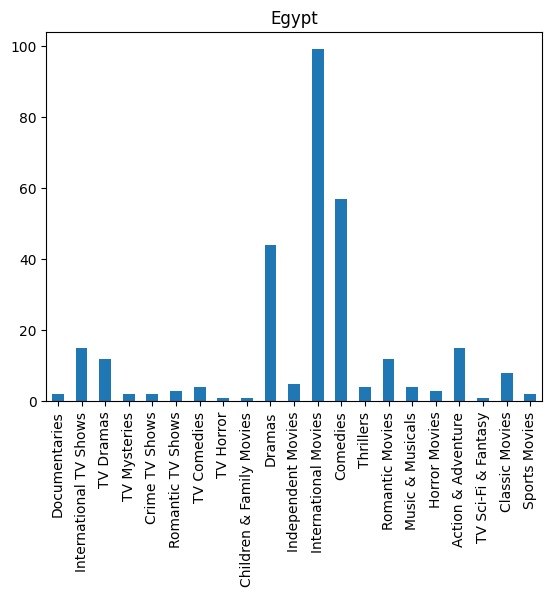

In [8]:
# understand distribution of different genres in countries with more than 100 movies
countries = c_count[c_count > 100].index
genres = pd.DataFrame(data=np.zeros([len(countries), len(genre_list)], dtype=int), index=countries, columns=genre_list, dtype=int)
for c in countries:
    for i in range(df_temp.shape[0]):
        cc = df_temp.iloc[i].country
        lst = cc.split(',')
        lst = [x.strip(' ') for x in lst if x != '']
        if c in lst:
            gg = df_temp.iloc[i].listed_in
            g_lst = gg.split(',')
            g_lst = [x.strip(' ') for x in g_lst if x != '']
            for g in g_lst:
                genres.loc[c].loc[g] += 1

plt.close('all')
for i in range(genres.shape[0]):
    plt.figure()
    row = genres.iloc[i]
    row = row[row != 0]
    row.plot(kind='bar', title=genres.index[i])
    

In [9]:
# extract top 3 movie genres for each country
for i in range(genres.shape[0]):
    row = genres.iloc[i]
    row = row[row != 0]
    row.sort_values(ascending=False, inplace=True)
    print(genres.index[i], ': ', row[0:3].index.values)

United States :  ['Dramas' 'Comedies' 'Documentaries']
India :  ['International Movies' 'Dramas' 'Comedies']
United Kingdom :  ['British TV Shows' 'Dramas' 'International Movies']
Germany :  ['International Movies' 'Dramas' 'Comedies']
Mexico :  ['International Movies' 'Spanish-Language TV Shows' 'Dramas']
Turkey :  ['International Movies' 'Comedies' 'International TV Shows']
Australia :  ['Dramas' 'International TV Shows' 'International Movies']
France :  ['International Movies' 'Dramas' 'Independent Movies']
China :  ['International Movies' 'Action & Adventure' 'International TV Shows']
Canada :  ['Comedies' 'Dramas' 'Children & Family Movies']
Japan :  ['International TV Shows' 'Anime Series' 'International Movies']
Nigeria :  ['International Movies' 'Dramas' 'Comedies']
Spain :  ['International Movies' 'Dramas' 'International TV Shows']
South Korea :  ['International TV Shows' 'Korean TV Shows' 'Romantic TV Shows']
Hong Kong :  ['International Movies' 'Action & Adventure' 'Comedies

# TASK: Identify similar contents by matching text-based features
Before utilizing pre-trained embedding models, I first implement models like BoW, TF-IDF, and SkipGram to have a better understanding of how these models works.

In [10]:
# create an object for Bag of Words model
class BoW:
    def __init__(self):
        self.all_words = set()
        self.word_to_idx = {}
        self.idx_to_word = {}
        self.total_words = 0


    def fit(self, document):
        self._validate_document(document) 
        for sentence in document:
            words = self._data_preprocessing(sentence)
            # create a set of all words (no duplicate)
            for word in words:
                self.all_words.add(word)
            # set the mapping indexes
            for idx, word in enumerate(self.all_words):
                self.word_to_idx[word] = idx
                self.idx_to_word[idx] = word
            # hold the size of our vocabulary
            self.total_words = len(self.all_words)
            

    def transform(self, data):
        # check if the model is fit
        if self.total_words == 0:
            raise AttributeError("You must first fit the data.")
        # if data is a single sentence
        if type(data) == str:
            words = self._data_preprocessing(data)
            transformed = self._transform_single(words)
        # if data is a list of sentences
        else:
            self._validate_document(data)
            transformed = np.empty((len(data), self.total_words))
            for row, sentence in enumerate(data):
                words = self._data_preprocessing(sentence)
                transformed[row] = self._transform_single(words)
        return transformed
        

    def _transform_single(self, list_of_words):
        transformed = np.zeros(self.total_words)
        for word in list_of_words:
            if word in self.all_words:
                idx = self.word_to_idx[word]
                transformed[idx] += 1
        return transformed
        

    def _validate_document(self, data):
        # check if data is an incorrect input
        red_flag = False
        if type(data) != list or len(data) < 1:
            red_flag = True
        else:
            for item in data:
                if type(item) != str:
                    red_flag = True
        if red_flag:
            raise TypeError("You must pass a list of strings as input.")


    def _normalize(self, sentence):
        data = sentence.lower()
        data = re.sub(r'\d+', '', data)
        data = re.sub(r'[^\w\s]', '', data)
        data = data.strip()
        words = data.split()
        normalized = ""
        for word in words:
            if word not in stop_words:
                normalized += word + " "
        normalized = normalized.rstrip()
        return normalized

    
    def _lemmatize(self, sentence):
        for word, tag in pos_tag(sentence.split()):
            if tag.startswith('NN'):
                yield WordNetLemmatizer().lemmatize(word, pos='n')
            elif tag.startswith('VB'):
                yield WordNetLemmatizer().lemmatize(word, pos='v')
            elif tag.startswith('JJ'):
                yield WordNetLemmatizer().lemmatize(word, pos='a')
            else:
                yield word

    
    def _data_preprocessing(self, sentence):
        # normalization
        normalized_sentence = self._normalize(sentence)
        # lemmatization
        lemmatized_sentence = ' '.join(self._lemmatize(normalized_sentence))
        # tokenizing
        words = lemmatized_sentence.split()
        return words

In [11]:
sentences = ['this is a list of sentences', 'second sentence in the list of sentences', 'a word for complexity']
bow = BoW()
bow.fit(sentences)
print(bow.idx_to_word)
print(bow.transform(sentences))

{0: 'second', 1: 'word', 2: 'list', 3: 'complexity', 4: 'sentence'}
[[0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 2.]
 [0. 1. 0. 1. 0.]]


In [12]:
# create one hot encoding model
class OneHot:
    def __init__(self):
        self.all_words = set()
        self.word_to_idx = {}
        self.idx_to_word = {}
        self.total_words = 0


    def fit(self, document):
        """
        Create a dictionary of all words in document and keep track of their indexes.
        Arguments
        ---------
        document: a list of strings.
            data to extract all words from.
        Exceptions
        ----------
        TypeError
            related to data type. Expects list of strings.
        """
        self._validate_document(document)
        for sentence in document:
            normalized = BoW()._data_preprocessing(sentence)
            for word in normalized:
                self.all_words.add(word)
        for idx, word in enumerate(self.all_words):
            self.word_to_idx[word] = idx
            self.idx_to_word[idx] = word
        self.total_words = len(self.all_words)


    def transform(self, data):
        """
        Transform data to a one hot vector based on fit model.
        Arguments
        ---------
        data: a string or list of strings.
            data to be transformed into one hot encoding.
        Exceptions
        ----------
        TypeError
            related to data type. Expects string or list of strings.
        AttributeError
            related to vocabulary length. Happens if fit with empty data or not fit.
        """
        if self.total_words == 0:
            raise AttributeError("You need to fit the model first.")
        if isinstance(data, str):
            return self._transform_single(data)
        elif isinstance(data, list):
            self._validate_document(data)
            return self._transform_document(data)


    def _transform_single(self, data):
        transformed = np.zeros(self.total_words)
        normalized = BoW()._data_preprocessing(data)
        for word in normalized:
            if word in self.all_words:
                transformed[self.word_to_idx[word]] = 1
        return transformed


    def _transform_document(self, data):
        transformed = np.empty((len(data), self.total_words))
        for row, sentence in enumerate(data):
            transformed[row] = self._transform_single(sentence)
        return transformed
            
    
    def _validate_document(self, data):
        # check if data is not a list of strings
        red_flag = False
        if type(data) != list or len(data) < 1:
            red_flag = True
        else:
            for item in data:
                if type(item) != str:
                    red_flag = True
        if red_flag:
            raise TypeError("You must pass a list of strings as input.")      

In [13]:
sentences = ['this is a list of sentences', 'second sentence in the list of sentences', 'a word for complexity']
one_hot = OneHot()
one_hot.fit(sentences)
print(one_hot.idx_to_word)
print(one_hot.transform(sentences))

{0: 'second', 1: 'word', 2: 'list', 3: 'complexity', 4: 'sentence'}
[[0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0.]]


In [14]:
# implement TF-IDF algorithm
def term_frequency(sentence, ignore_tokens=["<SOS>", "<EOS>"]):
    """
    Find the frequency of each word in a sentence. 
    This is an auxiliary function for later use.
    Arguments
    ---------
    sentence: of string type.
        data to get the frequency of each word.
    ignore_tokens: list of strings.
        tokens to ignore when counting the frequency of each word.
    """
    words_dict = {}
    for word in sentence:
        if word not in ignore_tokens:
            words_dict[word] = words_dict.get(word, 0) + 1
    return words_dict

class TFIDF:
    def __init__(self):
        self.word_to_idx = {}
        self.idx_to_word = {}
        self.idf_dict = {}
        self.num_documents = 0


    def fit(self, document):
        """
        Fits the data into featurizer.
        Arguments
        ---------
        document: list of strings.
            The data to fit the featurizer.
        Exceptions
        ----------
        TypeError
            Related to data type. Expects list of strings. 
        """
        BoW()._validate_document(document)
        self.num_documents = len(document)
        global_term_freq = {}
        for sentence in document:
            words_in_sen = set()
            normalized = BoW()._data_preprocessing(sentence)
            words_dict = term_frequency(normalized)
            for word in words_dict:
                if word not in words_in_sen:
                    global_term_freq[word] = global_term_freq.get(word, 0) + 1

        for word, frequency in global_term_freq.items():
            idf = math.log(float(1 + self.num_documents)/(1 + frequency))
            self.idf_dict[word] = idf

        document_words = list(global_term_freq.keys())
        for i in range(len(document_words)):
            word = document_words[i]
            self.word_to_idx[word] = i
            self.idx_to_word[i] = word

    
    def transform(self, data):
        """
        Transform input data based on featurizer.
        Arguments
        ---------
        data: string or list of strings.
            the data to transform.
        Exceptions
        ----------
        TypeError
            Related to data type. Expects string or list of strings.
        AttributeError
            Related to vocabulary length. Happens if fit with empty data or not fit.
        """
        if self.num_documents == 0:
            raise AttributeError("You must first fit the data.")
        if isinstance(data, str):
            return self._transform_sentence(data)
        elif isinstance(data, list):
            BoW()._validate_document(data)
            return self._transform_document(data)


    def _transform_document(self, document):
        sent_arrays = []
        for sentence in document:
            sent_arrays.append(self._transform_sentence(sentence))
        return np.matrix(sent_arrays)

        
    def _transform_sentence(self, sentence):
        transformed = np.zeros(len(self.word_to_idx))
        normalized = BoW()._data_preprocessing(sentence)
        words_dict = term_frequency(normalized)
        total_words = sum(words_dict.values())
        averaged_freq = {k:(float(v)/total_words) for k,v in words_dict.items()}
        for word, tf in averaged_freq.items():
            if word in self.word_to_idx:
                idx = self.word_to_idx[word]
                transformed[idx] = tf * self.idf_dict[word]
        return transformed 

In [15]:
sentences = ['this is a list of sentences', 'second sentence in the list of sentences', 'a word for complexity']
featurizer = TFIDF()
featurizer.fit(sentences)
print(featurizer.idx_to_word)
print(featurizer.transform(sentences))

{0: 'list', 1: 'sentence', 2: 'second', 3: 'word', 4: 'complexity'}
[[0.14384104 0.14384104 0.         0.         0.        ]
 [0.07192052 0.14384104 0.1732868  0.         0.        ]
 [0.         0.         0.         0.34657359 0.34657359]]


Since BoW and TF-IDF cannot extract contextual information from the text, and thus we won't be able to derive the similarity between sentences, we have to exploit embeddings in order to do so.

There are two methods: CBOW and SkipGram:

CBOW: predict a center word from context (neighboring words with according to window size)

SkipGram: predict context words given the center word or target

In this part, I impelement SkipGram from scratch.

In [16]:
# SkipGram
def Softmax(y):
    """
    Calculate the probability for each element of the output vector to have a better understanding 
    of what words are more likely to be the context words.
    """
    e_y = np.exp(y - np.max(y))
    return e_y / e_y.sum()


class w2vec:
    """
    SkipGram inplementation. We employ stochastic gradient descent for backpropagation.
    Vx1: dimension of input layer
    Nx1: dimension of hidden layer
    """
    def __init__(self):
        self.N = 10 # number of nodes in hidden layer
        self.alpha = 0.001 # learning rate
        self.window_size = 2 # sliding window for context words
        self.X_train = []
        self.y_train = []
        self.words = []
        self.word_index = {}


    def initialize(self, V, data):
        """
        Initialize weight matrices of neural network and our vocabulary.
        Arguments
        ---------
        V: number of words in dictionary (int)
        data: dictonary (list of words)
        """
        self.V = V
        self.W = np.random.uniform(-0.8, 0.8, (self.V, self.N)) # W: weight matrix between input layer and hidden layer
        self.W1 = np.random.uniform(-0.8, 0.8, (self.N, self.V)) # W1: weight matrix between hidden layer and output layer
        
        self.words = data
        for i in range(len(data)):
            self.word_index[data[i]] = i


    def feed_forward(self, X):
        """
        X: one hot encoding of an input word with dimension Vx1
        """
        self.h = np.dot(self.W.T, X).reshape(self.N, 1) # values of hidden layer
        self.u = np.dot(self.W1.T, self.h) # values of last layer
        self.y = Softmax(self.u) # values of output layer after passing through softmax layer
        return self.y


    def back_propagation(self, x, t):
        """
        Formula for backpropagation:
            dE/dW1 = e.h
            dE/dW = e.W1.x
        Arguments
        ---------
        x: one hot encoding of an input word
        t: real output values for input x (one hot encoding of context words based on window size)
        """
        e = self.y - np.asarray(t).reshape(self.V,1)
        dLdW1 = np.dot(self.h, e.T)
        X = np.array(x).reshape(self.V, 1)
        dLdW = np.dot(X, np.dot(self.W1, e).T)
        self.W1 = self.W1 - self.alpha*dLdW1
        self.W = self.W - self.alpha*dLdW
    

    def train(self, epoch):
        for i in range(epoch):
            self.loss = 0
            for j in range(len(self.X_train)):
                self.feed_forward(self.X_train[j])
                self.back_propagation(self.X_train[j], self.y_train[j])
            # calculate loss function
            C = 0
            for m in range(self.V):
                if self.y_train[j][m]:
                    self.loss += -1*self.u[m][0]
                    C += 1
            self.loss += C*np.log(np.sum(np.exp(self.u)))
            print('epoch', i, 'loss:', self.loss)
        self.alpha *= 1 / (1 + self.alpha*i)

    
    def predict(self, word, num_of_predictions):
        if word in self.words:
            X = [0 for i in range(self.V)]
            X[self.word_index[word]] = 1
            prediction = self.feed_forward(X)
            output = {}
            for i in range(self.V):
                output[prediction[i][0]] = i
            context_words = []
            for k in sorted(output, reverse=True):
                context_words.append(self.words[output[k]])
                if len(context_words) >= num_of_predictions:
                    break
            return context_words
        else:
            print("Word not found in dictionary.")


def normalize(sentence):
        data = sentence.lower()
        data = re.sub(r'\d+', '', data)
        data = re.sub(r'[^\w\s]', '', data)
        data = data.strip()
        return data

    
def lemmatize(sentence):
    for word, tag in pos_tag(sentence.split()):
        if tag.startswith('NN'):
            yield WordNetLemmatizer().lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            yield WordNetLemmatizer().lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            yield WordNetLemmatizer().lemmatize(word, pos='a')
        else:
            yield word


def data_preprocessing(document):
    training_data = []
    for sentence in document:
        # normalization
        normalized_sentence = normalize(sentence)
        # lemmatization
        lemmatized_sentence = ' '.join(lemmatize(normalized_sentence))
        # remove stop words
        no_stopwords = ""
        words = lemmatized_sentence.split()
        for word in words:
            if word not in stop_words:
                no_stopwords += word + " "
        no_stopwords = no_stopwords.rstrip()
        # tokenizing
        data = no_stopwords.split()
        training_data.append(data)
    return training_data

  
def prepare_data_for_training(sentences,w2v):
    data = {}
    for sentence in sentences:
        for word in sentence:
            if word not in data:
                data[word] = 1
            else:
                data[word] += 1
    V = len(data)
    data = sorted(list(data.keys()))
    vocab = {}
    for i in range(len(data)):
        vocab[data[i]] = i
      
    for sentence in sentences:
        for i in range(len(sentence)):
            center_word = [0 for x in range(V)]
            center_word[vocab[sentence[i]]] = 1
            context = [0 for x in range(V)]
             
            for j in range(i-w2v.window_size,i+w2v.window_size):
                if i!=j and j>=0 and j<len(sentence):
                    context[vocab[sentence[j]]] += 1
            w2v.X_train.append(center_word)
            w2v.y_train.append(context)
    w2v.initialize(V,data)
  
    return w2v.X_train,w2v.y_train  

In [17]:
sentences = 'The earth revolves around the sun. The moon revolves around the earth.'
data = sentences.split('.')
epoch = 1000
w2v = w2vec()
training_data = data_preprocessing(data)
prepare_data_for_training(training_data, w2v)
w2v.train(epoch)
word = 'around'
print('\npredicted context words for word', '\'' + word + '\':\n', w2v.predict(word,3))
print('result of embedding:\n' , w2v.y)
print('words and their indexes in dictionary:\n', w2v.word_index)

epoch 0 loss: 5.631501973992
epoch 1 loss: 5.610094430151625
epoch 2 loss: 5.588813821808647
epoch 3 loss: 5.567659153837601
epoch 4 loss: 5.546629438734824
epoch 5 loss: 5.525723696573956
epoch 6 loss: 5.5049409549619845
epoch 7 loss: 5.484280248995796
epoch 8 loss: 5.463740621219252
epoch 9 loss: 5.4433211215807455
epoch 10 loss: 5.4230208073912225
epoch 11 loss: 5.402838743282677
epoch 12 loss: 5.382774001167069
epoch 13 loss: 5.362825660195686
epoch 14 loss: 5.342992806718897
epoch 15 loss: 5.323274534246316
epoch 16 loss: 5.303669943407344
epoch 17 loss: 5.284178141912076
epoch 18 loss: 5.264798244512562
epoch 19 loss: 5.2455293729644135
epoch 20 loss: 5.226370655988737
epoch 21 loss: 5.207321229234381
epoch 22 loss: 5.18838023524049
epoch 23 loss: 5.169546823399342
epoch 24 loss: 5.150820149919479
epoch 25 loss: 5.132199377789095
epoch 26 loss: 5.113683676739692
epoch 27 loss: 5.095272223209971
epoch 28 loss: 5.076964200309972
epoch 29 loss: 5.0587587977854325
epoch 30 loss: 5.04

In [18]:
# use a pre-trained word2vec model and extract vector embeddings of our data
# use cosine similarity to find similar content descriptions of the movies
wv = api.load('word2vec-google-news-300')

In [19]:
descriptions = df.loc[:, 'description']
descriptions.index = df.loc[:, 'show_id'].values
documents = descriptions.values.tolist()
doc_embedding = {}
for i in range(len(documents)):
    description = normalize(documents[i])
    embedding = np.zeros(wv.vector_size)
    for word in description.split():
        try:
            embedding += wv[word] # this is a word2vec representation of a movie description
        except KeyError:
            pass
    doc_embedding[descriptions.index[i]] = embedding

In [20]:
similarities = {}
for key, value in doc_embedding.items():
    for k, v in doc_embedding.items():
        if key != k and frozenset([key,k]) not in similarities.keys():
            similarities[frozenset([key, k])] = 1 - distance.cosine(value, v)


In [21]:
top_similars = {}
for k, v in similarities.items():
    if v > 0.8:
        top_similars[k] = v
for id in sorted(top_similars, reverse=True):
    id1, id2 = id
    print('similar contents:', '\n1.', descriptions[id1], '\n2.', descriptions[id2])

similar contents: 
1. As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable. 
2. Grieving after a tragedy, Malcolm tries to start fresh with his new girlfriend and her kids — but supernatural shenanigans find their way back to him.
similar contents: 
1. Brian knows there are creatures under his bed. When he faces his fears and confronts them, however, he makes some hilariously weird new friends. 
2. As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable.
similar contents: 
1. As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable. 
2. Struggling to come to terms with his wife's death, a writer for a newspaper adopts a gruff new persona in an effort to push away those trying to help.
similar contents

# We can see the model has found similar contents successfully in most cases.

Most of the examples above with cosine value above 0.8 are alike. For example, the model has grouped sentences about death, near-death experience and starting anew after a tragedy in one's life, or sentences about marriage and relationships, or about teens, sharing a house, and their other stories.

The model has found interesting relations between some contents as well. For instance in the example below, the model has identified it's a father and daughter relationship, thus the stories can be similar:

1. After years in the U.S., a Taiwanese immigrant returns to her hometown with a young daughter in tow to assist her father with his bed-and-breakfast. 
2. Newly divorced and denied visitation rights with his daughter, a doting father disguises himself as a gray-haired nanny in order to spend time with her.
